In [1]:
from typing import Optional

import torch
from omegaconf import OmegaConf
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import Logger, TensorBoardLogger, WandbLogger

from tsl import logger
from tsl.data import SpatioTemporalDataModule, SpatioTemporalDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import MetrLA, PemsBay, AirQuality
from tsl.datasets.pems_benchmarks import PeMS03, PeMS04, PeMS07, PeMS08
from tsl.engines import Predictor
from tsl.experiment import Experiment, NeptuneLogger
from tsl.metrics import numpy as numpy_metrics
from tsl.metrics import torch as torch_metrics
from tsl.nn import models
from tsl.utils.casting import torch_to_numpy

from my_datasets import AirQualitySmallerFore, AirQualityAucklandFore

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def get_model_class(model_str):
    # Spatiotemporal Models ###################################################
    if model_str == 'dcrnn':
        model = models.DCRNNModel  # (Li et al., ICLR 2018)
    elif model_str == 'gwnet':
        model = models.GraphWaveNetModel  # (Wu et al., IJCAI 2019)
    elif model_str == 'evolvegcn':
        model = models.EvolveGCNModel  # (Pereja et al., AAAI 2020)
    elif model_str == 'agcrn':
        model = models.AGCRNModel  # (Bai et al., NeurIPS 2020)
    elif model_str == 'grugcn':
        model = models.GRUGCNModel  # (Guo et al., ICML 2022)
    elif model_str == 'gatedgn':
        model = models.GatedGraphNetworkModel  # (Satorras et al., 2022)
    elif model_str == 'stcn':
        model = models.STCNModel
    elif model_str == 'transformer':
        model = models.TransformerModel
    # Temporal Models #########################################################
    elif model_str == 'ar':
        model = models.ARModel
    elif model_str == 'var':
        model = models.VARModel
    elif model_str == 'rnn':
        model = models.RNNModel
    elif model_str == 'fcrnn':
        model = models.FCRNNModel
    elif model_str == 'tcn':
        model = models.TCNModel
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model


def get_dataset(dataset_name: str, agg_func = 'mean'):
    if dataset_name == 'air':
        return AirQuality(impute_nans=True, small=True)
    elif dataset_name == 'air_smaller':
        return AirQualitySmallerFore('../../../AirData/AQI/Stations', impute_nans=True)
    elif dataset_name == 'air_auckland':
        return AirQualityAucklandFore('../../../AirData/Niwa', t_range=['2022-04-01', '2022-12-01'], 
                                   agg_func=agg_func)
    elif dataset_name == 'la':
        dataset = MetrLA(impute_zeros=True)  # From Li et al. (ICLR 2018)
    elif dataset_name == 'bay':
        dataset = PemsBay()  # From Li et al. (ICLR 2018)
    elif dataset_name == 'pems3':
        dataset = PeMS03()  # From Guo et al. (2021)
    elif dataset_name == 'pems4':
        dataset = PeMS04()  # From Guo et al. (2021)
    elif dataset_name == 'pems7':
        dataset = PeMS07()  # From Guo et al. (2021)
    elif dataset_name == 'pems8':
        dataset = PeMS08()  # From Guo et al. (2021)
    else:
        raise ValueError(f"Dataset {dataset_name} not available.")
    return dataset

In [3]:
def load_model_and_infer(og_path: str):
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    assert len(result)
    checkpoint_path = result[0]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    
    # Load dataset
    try:
        dataset = get_dataset(cfg.dataset.name,
                            agg_func=cfg.dataset.agg_func)
    except:
        dataset = get_dataset(cfg.dataset.name)

    covariates = {'u': dataset.datetime_encoded('day').values}

    # get adjacency matrix
    adj = dataset.get_connectivity(**cfg.dataset.connectivity)

    torch_dataset = SpatioTemporalDataset(
        target=dataset.dataframe(),
        mask=dataset.mask,
        connectivity=adj,
        covariates=covariates,
        horizon=cfg.horizon,
        window=cfg.window,
        stride=cfg.stride,
    )
    
    transform = {'target': StandardScaler(axis=(0, 1))}  # axis: time&space

    dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=transform,
        splitter=dataset.get_splitter(**cfg.dataset.splitting),
        batch_size=cfg.batch_size,
        workers=cfg.workers,
    )
    dm.setup()
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    
    model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                    input_size=torch_dataset.n_channels,
                    output_size=torch_dataset.n_channels,
                    horizon=torch_dataset.horizon,
                    exog_size=torch_dataset.input_map.u.shape[-1])
    
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)

    trainer = Trainer(
        max_epochs=cfg.epochs,
        default_root_dir=cfg.run.dir,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        gradient_clip_val=cfg.grad_clip_val
    )
    
    predictor = Predictor.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)
    predictor.freeze()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(predictor, dataloaders=dm.test_dataloader())
    output = predictor.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask = (output['y_hat'], output['y'],
                           output.get('eval_mask', None))
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask))
    
    return y_hat, y_true, mask, res, dm, dataset


In [29]:
checkpoint_path = '../logs/dcrnn/air_auckland/2025-02-22/00-31-56'  # Path to model checkpoint
checkpoint_path = '../logs/grugcn/air_auckland/2025-02-22/00-21-08' 
checkpoint_path = '../logs/rnn/air_auckland/2025-02-22/00-16-25'


y_hat, y_true, mask, res, dm, dataset = load_model_and_infer(checkpoint_path)
res

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]
/home/mala711/GNNstuff/GNNthesis/pipenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Arguments ['edge_weight', 'edge_index'] are filtered out. Only args ['u', 'x'] are forwarded to the model (RNNModel).


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 216.29it/s]


{'test_mae': 4.3553433,
 'test_mre': 0.44446600049946944,
 'test_mape': 0.5228619}

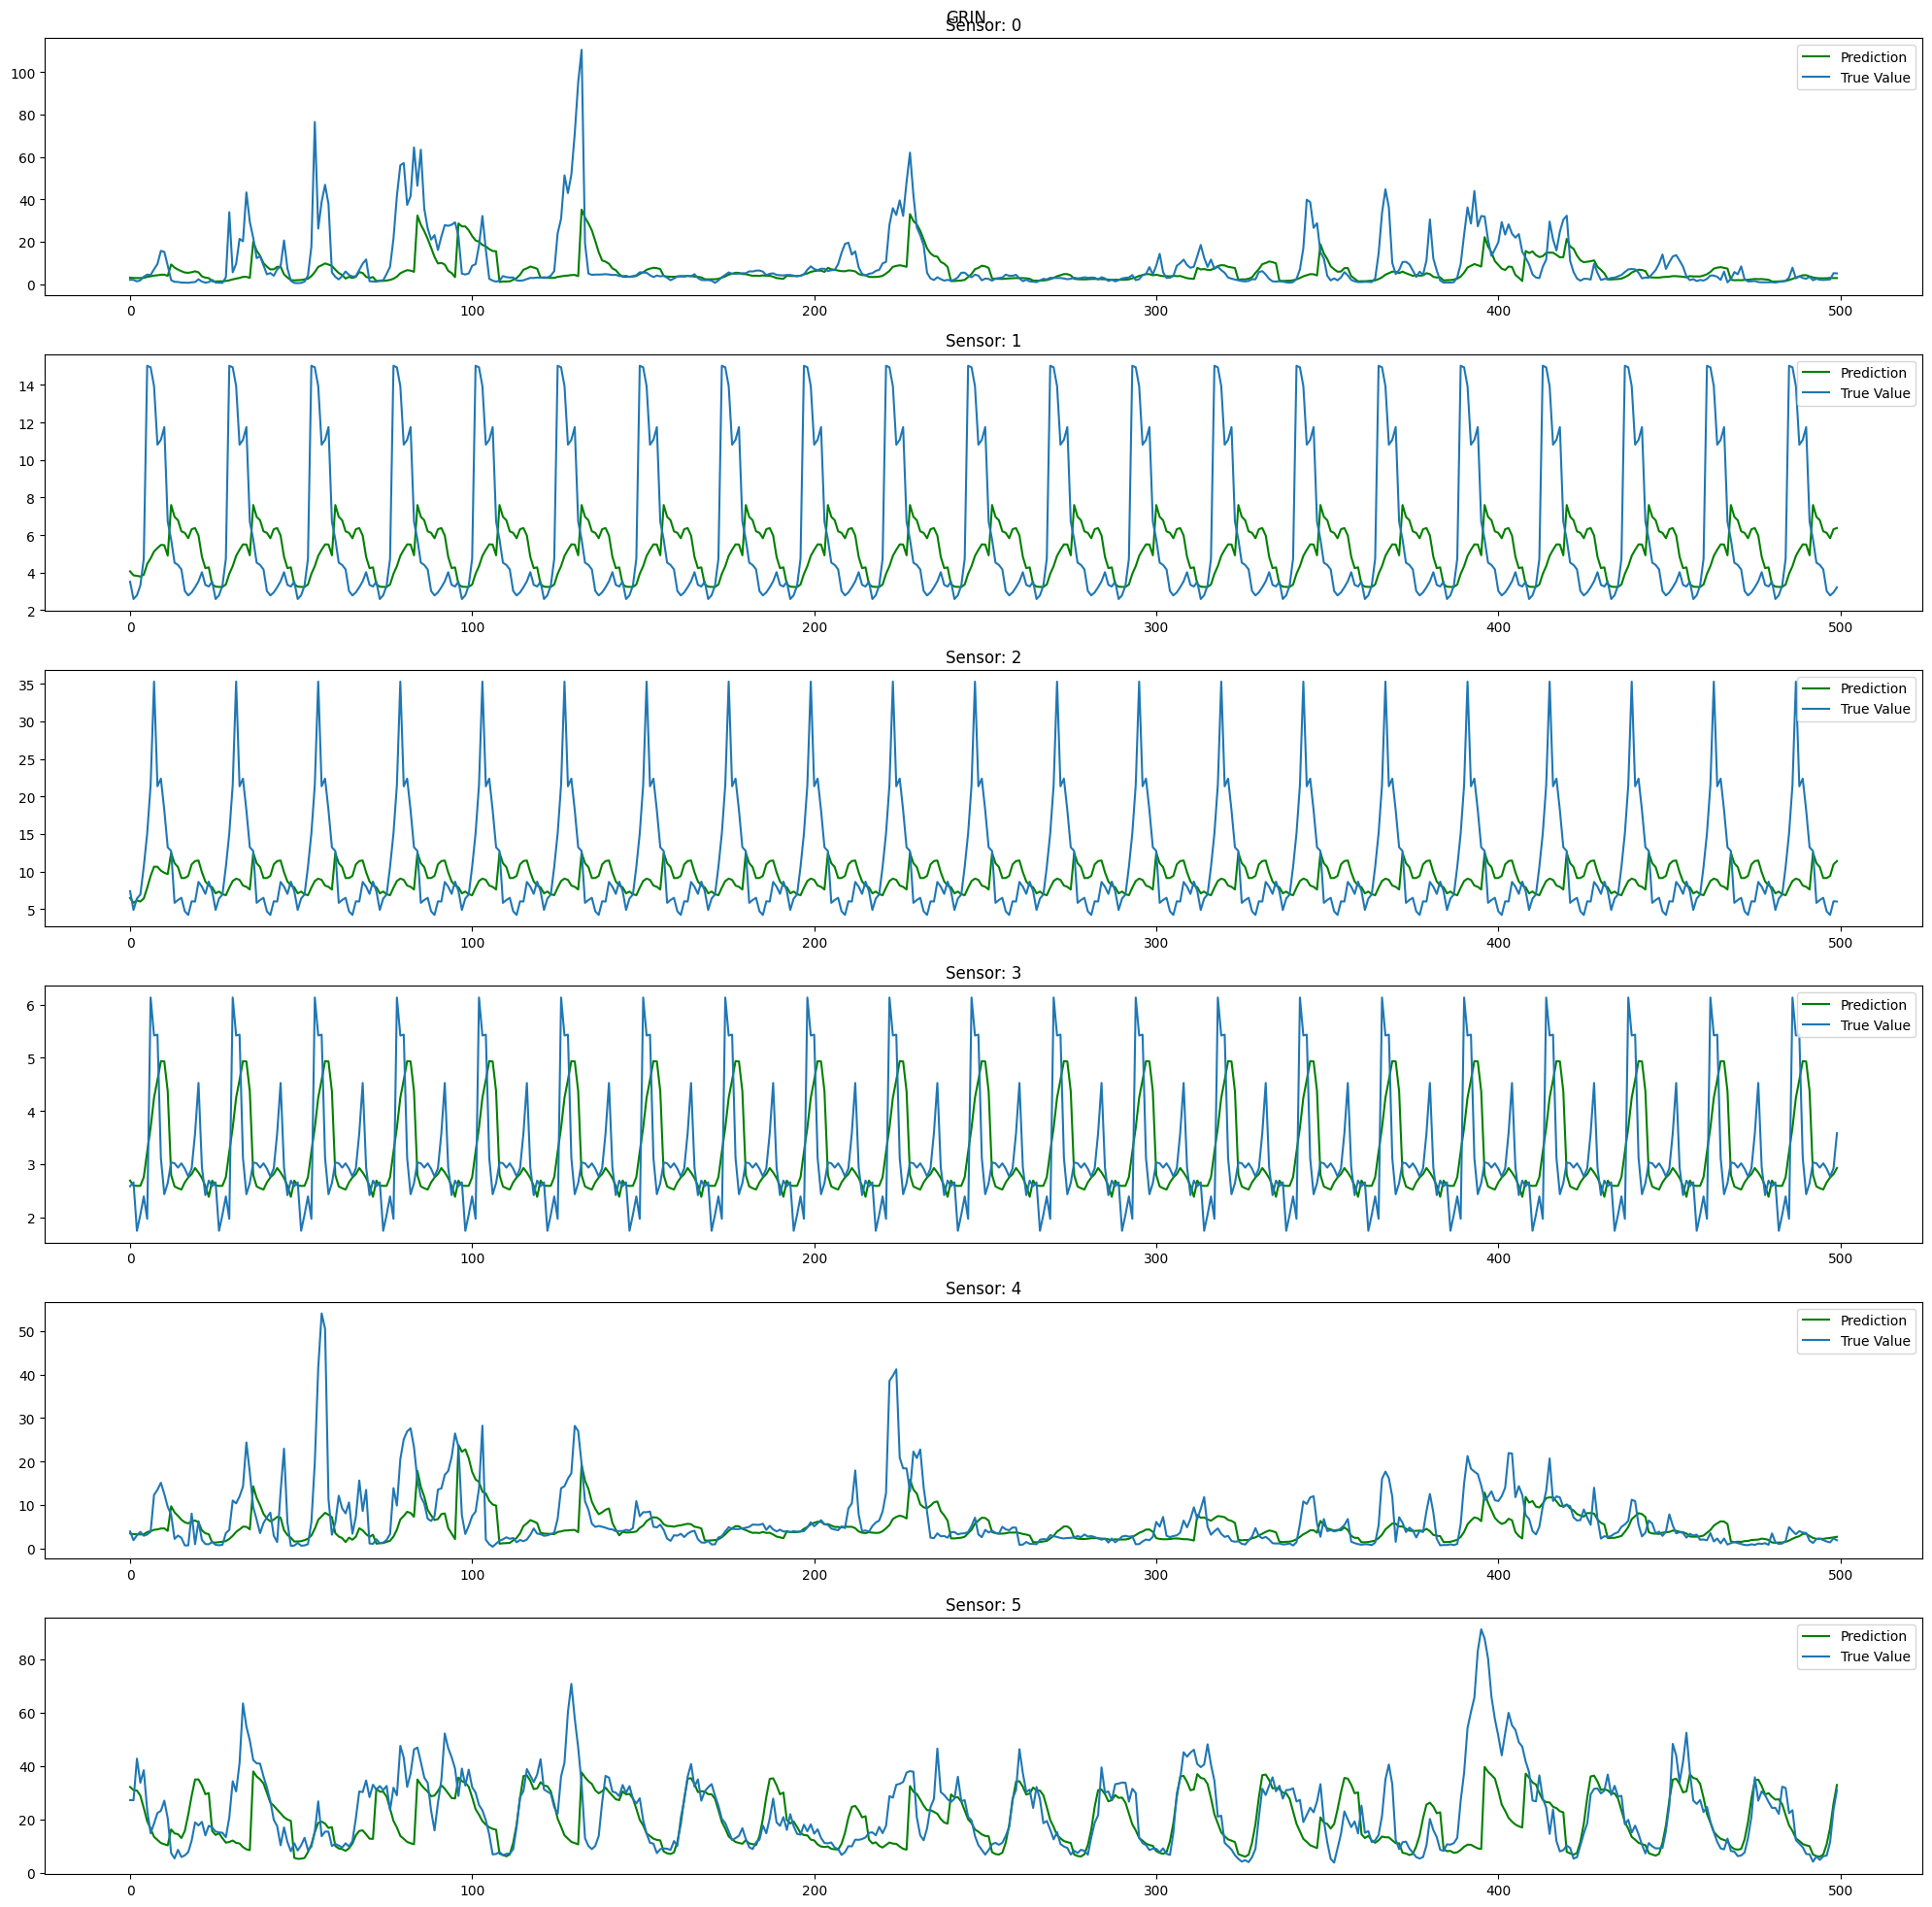

In [30]:
graph_hat = y_hat.reshape(y_hat.shape[0]*y_hat.shape[1], y_hat.shape[2], y_hat.shape[3])
graph_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2], y_true.shape[3])

ranges = [0, 500]
# indices = torch.where(torch.sum(dm.eval_mask, dim=0) > 0)[0]
indices = list(range(y_hat.shape[2]))

if len(indices) == 1:
    plt.figure(figsize=(15,7))
    plt.plot(graph_hat[ranges[0]:ranges[1], indices[0], 0], color='g', label='Prediction')
    plt.plot(graph_true[ranges[0]:ranges[1], indices[0], 0], label='True Value')
    plt.title(f'GRIN, Sensor: {indices[0]}')
    plt.legend()
    plt.show()

else:
    fig, axs = plt.subplots(len(indices), 1, figsize=(20,20))

    for i, ax in enumerate(axs.flatten()):
        ax.plot(graph_hat[ranges[0]:ranges[1], indices[i], 0], color='g', label='Prediction')
        ax.plot(graph_true[ranges[0]:ranges[1], indices[i], 0], label='True Value')
        ax.set_title(f'Sensor: {indices[i]}')
        ax.legend()

    fig.suptitle('GRIN')
    fig.tight_layout()
    plt.show()

In [7]:
dm.test_slice

tensor([2172, 2173, 2174,  ..., 3669, 3670, 3671])

In [8]:
y_hat.shape

(124, 12, 6, 1)

In [9]:
indices

[0, 1, 2, 3, 4]

In [10]:
m = np.mean(y_true, axis=1)

In [11]:
m.shape

(124, 6, 1)

In [12]:
graph_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2], y_true.shape[3])

In [13]:
dm

SpatioTemporalDataModule(train_len=345, val_len=18, test_len=124, scalers=[target], batch_size=64)

In [14]:
dm.torch_dataset.dataframe()

nodes,0,1,2,3,4,5
channels,0,0,0,0,0,0
datetime,,,,,,
2022-04-01 00:00:00+00:00,3.100000,2.673333,3.410000,7.001429,2.084038,26.935846
2022-04-01 01:00:00+00:00,3.182500,2.705000,3.127500,7.156667,1.952051,26.430929
2022-04-01 02:00:00+00:00,3.036667,2.400000,3.140000,5.253750,1.909407,26.247177
2022-04-01 03:00:00+00:00,3.560000,2.370000,3.030000,4.761667,2.000657,25.495037
2022-04-01 04:00:00+00:00,3.796667,2.780000,3.263333,4.273750,2.001064,22.854179
...,...,...,...,...,...,...
2022-11-30 19:00:00+00:00,4.507500,3.220572,6.007094,3.583112,4.593333,31.510000
2022-11-30 20:00:00+00:00,3.830000,3.538578,8.621893,4.527214,4.425000,31.017500


In [15]:
np.array(dataset.df.iloc[2184:3671, 4])

array([3.8533332, 1.865    , 2.9666667, ..., 4.62     , 4.0575   ,
       1.6033334], dtype=float32)

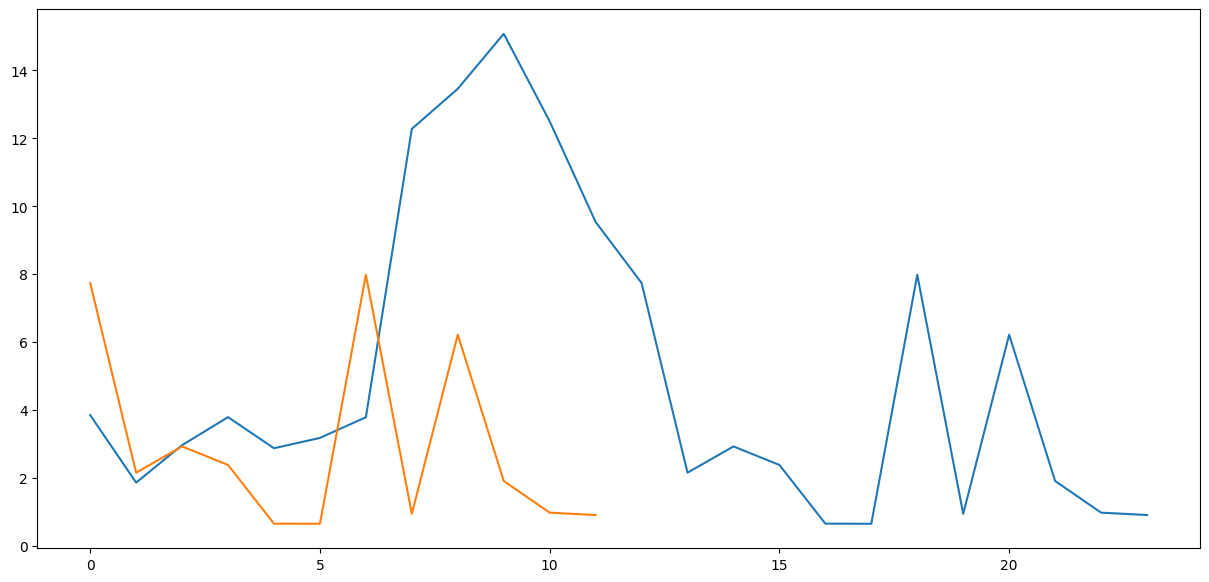

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(np.array(dm.torch_dataset.dataframe().iloc[2184:2184+24, 4]))
plt.plot(y_true[1, :, 4, :])
plt.show()

In [17]:
y_hat.shape

(124, 12, 6, 1)

In [18]:
dm.torch_dataset

SpatioTemporalDataset(n_samples=487, n_nodes=6, n_channels=1)

In [19]:
dm.test_dataloader()

In [20]:
dm.mask

tensor([[[ True],
         [ True],
         [ True],
         [ True],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         [ True],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         [ True],
         [False],
         [False]],

        ...,

        [[ True],
         [False],
         [False],
         [False],
         [ True],
         [ True]],

        [[ True],
         [False],
         [False],
         [False],
         [ True],
         [ True]],

        [[ True],
         [False],
         [False],
         [False],
         [ True],
         [ True]]])

In [21]:
torch.where(torch.sum(dm.eval_mask, dim=0) > 0)

AttributeError: eval_mask

In [ ]:
torch.sum(dm.mask[:, 5, :])

tensor(4898)

In [ ]:
y_hat.shape

(124, 12, 6, 1)